In [1]:
library(arcgisbinding, quietly = TRUE)
library(leaflet, quietly = TRUE)
library(leaflet.esri, quietly = TRUE)
library(raster, quietly = TRUE)
library(reticulate, quietly = TRUE)
library(sf, quietly = TRUE)
library(vegclust, quietly = TRUE)

*** Please call arc.check_product() to define a desktop license.
Linking to GEOS 3.6.1, GDAL 2.2.3, proj.4 4.9.3


In [2]:
arc.check_product()

product: ArcGIS Pro (12.7.0.26828)
license: Advanced
version: 1.0.1.244

In [3]:
reticulate::use_python('C:/Users/orhu8849/AppData/Local/ESRI/conda/envs/r_env_2_7_1/python.exe', required = T)
ARCPY <- import('arcpy')

In [4]:
base_ecoregion_url <- 'https://services3.arcgis.com/oZfKvdlWHN1MwS48/arcgis/rest/services/Ecoregions/FeatureServer/0'
base_ecoregion_obj <- arc.open(base_ecoregion_url)
base_ecoregion_obj

dataset_type    : FeatureClass
path            : https://services3.arcgis.com/oZfKvdlWHN1MwS48/arcgis/rest/services/Ecoregions/FeatureServer/0 
fields          : OBJECTID, Join_Count, TARGET_FID, AREA, PERIMETER, ECOCODE, 
fields          : DOMAIN, DIVISION, PROVINCE, SECTION, FAPAR_max_zonal, 
fields          : FAPAR_mean_zonal, FAPAR_min_zonal, FAPAR_range_zonal, 
fields          : FAPAR_std_zonal, LAI_max_zonal, LAI_mean_zonal, 
fields          : LAI_min_zonal, LAI_range_zonal, LAI_std_zonal, 
fields          : precip_max_Zonal, precip_mean_Zonal, precip_min_Zonal, 
fields          : precip_range_Zonal, precip_std_Zonal, temp_max_Zonal, 
fields          : temp_mean_Zonal, temp_min_Zonal, temp_range_Zonal, 
fields          : temp_std_Zonal, Shape__Area, Shape__Length, Shape
extent          : xmin=72007.71, ymin=-1400196, xmax=4442157, ymax=1789102
geometry type   : Polygon
WKT             : PROJCS["Clarke_1866_Albers",GEOGCS["GCS_Clarke_1866",DATUM["... 

In [5]:
base_ecoregion_arc <- arc.select(base_ecoregion_obj)
base_ecoregion_sf <- st_as_sf(arc.data2sp(base_ecoregion_arc))
#plot(base_ecoregion_sf)

In [6]:
num.clust <- length(unique(base_ecoregion_sf$PROVINCE))
cluster.pal <- colorFactor(rainbow(num.clust), domain=base_ecoregion_sf$PROVINCE)

In [ ]:
L<-leaflet(elementId='ecoregion_map') %>%
    addProviderTiles(providers$Esri) %>%
    addPolygons(data = st_transform(base_ecoregion_sf, 4326),
                fillOpacity = 1,
                color=~cluster.pal(base_ecoregion_sf$PROVINCE),
                label=~sprintf("Ecoregion Province: %s", base_ecoregion_sf$PROVINCE))
L

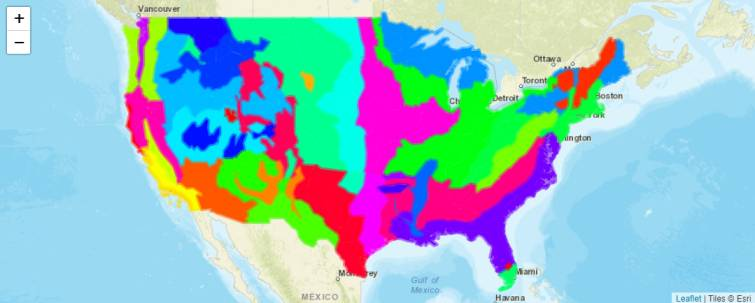

## Creating Data Driven Ecoregions

Use two methods to define ecoregions with clustering:
1. Spatially Constrained Multivariate Clustering (SKATER Algorithm) (`ArcGIS Pro`)
2. Hard C Medoid Clustering (`vegclust package`)

### Import `arcpy` to Perform Spatial Unsupervised Learning - Regionalization

In [8]:
ARCPY$env$overwriteOutput = TRUE
base.path <- ARCPY$management$CreateFileGDB(getwd(), "scratchGDB", "CURRENT")
ARCPY$env$workspace <- gsub("\\\\", "/", base.path)

In [9]:
out.fc <- file.path(base.path, 'skater_regions')
num.clust <- 25
ARCPY$stats$SpatiallyConstrainedMultivariateClustering(base_ecoregion_url, out.fc, "FAPAR_max_zonal;FAPAR_mean_zonal;FAPAR_min_zonal;FAPAR_range_zonal;LAI_max_zonal;LAI_mean_zonal;LAI_min_zonal;LAI_range_zonal;precip_max_Zonal;precip_mean_Zonal;precip_min_Zonal;precip_range_Zonal;temp_max_Zonal;temp_min_Zonal;temp_std_Zonal", "NONE", NULL, NULL, NULL, num.clust, "TRIMMED_DELAUNAY_TRIANGULATION", NULL, 0, NULL)

C:\Users\orhu8849\Documents\code\arcgis-r-api\samples\Notebooks\Spatial Data Science Examples\scratchGDB.gdb\skater_regions

### Read-In ArcGIS Pro Output Using R-ArcGIS Bridge

In [10]:
skater_regions <- arc.select(arc.open(out.fc), fields = c('CLUSTER_ID'))
skater_regions.sp <- arc.data2sp(skater_regions) ## Convert ArcGIS Pro Result to sp
skater_regions.sf <- st_as_sf(skater_regions.sp) ## Convert ArcGIS Pro Result to sf

In [ ]:
cluster.pal2 <- colorFactor(rainbow(num.clust), domain=skater_regions.sf$CLUSTER_ID)

L1 <-leaflet(elementId='ecoregion_map_skater') %>%
    addProviderTiles(providers$Esri) %>%
    addPolygons(data = st_transform(skater_regions.sf , 4326),
                fillOpacity = 1,
                color=~cluster.pal2(skater_regions.sf$CLUSTER_ID),
                label=~sprintf("Region Id: %s", skater_regions.sf$CLUSTER_ID))
L1

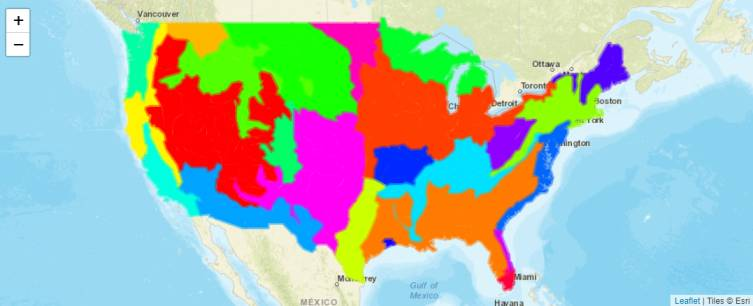

## Perform Hard C Medoid Clustering on Ecoregion Data

### Read local data on ecoregions

In [12]:
vars <- colnames(base_ecoregion_sf)[11:30]

eco.vars <- st_set_geometry(base_ecoregion_sf[vars], NULL)
non.na.inds <- complete.cases(eco.vars)
eco.vars <- eco.vars[non.na.inds, ]

### Perform Hard C Medoid Clustering from `vegclust` package

In [13]:
eco_groups <- vegclust(x = eco.vars, mobileCenters=num.clust, method="KMdd", nstart=20)

group_id <- defuzzify(eco_groups)$cluster
group_id <- unclass(factor(group_id))
base_ecoregion_sf[non.na.inds,'Defuzzy Groups'] <- group_id

### Write the Results Back to ArcGIS for Analysis

In [14]:
arc.write(file.path(base.path, 'vegclust_regions'), base_ecoregion_sf, overwrite=TRUE)